**Objective**: In this lab, you will implement and compare manual grid search with scikit-learn's built-in GridSearchCV for hyperparameter tuning. You'll work with multiple classification algorithms and combine them using voting classifiers.

**Learning Goals**:
- Understand hyperparameter tuning through grid search
- Compare manual implementation with built-in functions
- Learn to create and evaluate voting classifiers
- Work with multiple real-world datasets
- Visualize model performance using ROC curves and confusion matrices

**Datasets Used**:
1. Wine Quality - Predicting wine quality based on chemical properties
2. HR Attrition - Predicting employee turnover
3. Banknote Authentication - Detecting counterfeit banknotes
4. QSAR Biodegradation - Predicting chemical biodegradability



## Part 1: Import Libraries and Setup

First, let's import all the necessary libraries for our machine learning pipeline.

In [ ]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve,
                             confusion_matrix, ConfusionMatrixDisplay, classification_report)
# Bypass SSL certificate verification for dataset downloads
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Models and Parameter Grids

In [ ]:
# The parameter names must match the pipeline step names, e.g., 'classifier__max_depth'
# ToDo: Define base models (Decision Tree, kNN, Logistic Regression)

param_grid_dt = {
    'classifier__max_depth': [None, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], # Expanded max_depth
    'classifier__min_samples_split': [2, 5, 10, 15, 20, 25, 30], # Expanded min_samples_split
    'classifier__min_samples_leaf': [1, 2, 4, 6, 8, 10, 12], # Expanded min_samples_leaf
    'classifier__criterion': ['gini', 'entropy'] # Added criterion
}

param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21], # Expanded n_neighbors
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]
}

param_grid_lr = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], # Expanded C
    'classifier__penalty': ['l1', 'l2', None], # Corrected 'none' to None
    'classifier__solver': ['liblinear', 'saga'], # Added 'saga' solver (liblinear supports only l1 and l2)
    'classifier__max_iter': [200] # Corrected parameter name for max_iterations
}

# ToDo: Create a list of (classifier, param_grid, name) tuples
classifiers_to_tune = [
    (DecisionTreeClassifier(random_state=42), param_grid_dt, 'Decision Tree'),
    (KNeighborsClassifier(), param_grid_knn, 'k-Nearest Neighbors'),
    (LogisticRegression(random_state=42), param_grid_lr, 'Logistic Regression')
]

## Dataset Loading Functions
We'll work with four different datasets to test our algorithms across various domains.

### 3.1 Wine Quality Dataset


In [ ]:
# def load_wine_quality():
#     """Load Wine Quality dataset"""
#     url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
#     try:
#         data = pd.read_csv(url, sep=';')
#     except Exception as e:
#         print(f"Error loading Wine Quality dataset: {e}")
#         return None, None, None, None, "Wine Quality (Failed)"

#     # Create the binary target variable 'good_quality'
#     data['good_quality'] = (data['quality'] > 5).astype(int)
#     X = data.drop(['quality', 'good_quality'], axis=1)
#     y = data['good_quality']

#     # Train-test split
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=0.3, random_state=42, stratify=y
#     )

#     print("Wine Quality dataset loaded and preprocessed successfully.")
#     print(f"Training set shape: {X_train.shape}")
#     print(f"Testing set shape: {X_test.shape}")
#     return X_train, X_test, y_train, y_test, "Wine Quality"

### 3.2 HR Attrition Dataset


In [ ]:
def load_hr_attrition():
    """Load IBM HR Attrition dataset"""
    try:
        data = pd.read_csv("/content/WA_Fn-UseC_-HR-Employee-Attrition.csv")
    except FileNotFoundError:
        print("HR Attrition dataset not found. Please place 'WA_Fn-UseC_-HR-Employee-Attrition.csv' inside a 'data/' folder.")
        return None, None, None, None, "HR Attrition (Failed)"

    # Target: Attrition = Yes (1), No (0)
    data['Attrition'] = (data['Attrition'] == 'Yes').astype(int)

    # Drop ID-like column
    X = data.drop(['EmployeeNumber', 'Attrition'], axis=1, errors='ignore')
    y = data['Attrition']

    # One-hot encode categorical variables
    X = pd.get_dummies(X, drop_first=True)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.3, random_state=42
    )

    print("IBM HR Attrition dataset loaded and preprocessed successfully.")
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test, "HR Attrition"

### 3.3 Banknote Authentication Dataset



In [ ]:
# def load_banknote():
#     """Load Banknote Authentication dataset"""
#     url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"

#     try:
#         data = pd.read_csv(url, header=None)
#     except Exception as e:
#         print(f"Error loading Banknote dataset: {e}")
#         return None, None, None, None, "Banknote (Failed)"

#     # According to UCI: variance, skewness, curtosis, entropy, class (0=authentic, 1=fake)
#     X = data.iloc[:, :-1]
#     y = data.iloc[:, -1]

#     # Train-test split
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, stratify=y, test_size=0.3, random_state=42
#     )

#     print("Banknote Authentication dataset loaded successfully.")
#     print(f"Training set shape: {X_train.shape}")
#     print(f"Testing set shape: {X_test.shape}")
#     return X_train, X_test, y_train, y_test, "Banknote Authentication"


### 3.4 QSAR Biodegradation Dataset





In [ ]:
# def load_qsar_biodegradation():
#     """Load QSAR Biodegradation dataset"""
#     url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00254/biodeg.csv"

#     try:
#         data = pd.read_csv(url, sep=';', header=None)
#     except Exception as e:
#         print(f"Error loading QSAR dataset: {e}")
#         return None, None, None, None, "QSAR (Failed)"

#     # Last column is target (RB = ready biodegradable, NRB = not)
#     X = data.iloc[:, :-1]
#     y = (data.iloc[:, -1] == 'RB').astype(int)

#     # Train-test split
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, stratify=y, test_size=0.3, random_state=42
#     )

#     print("QSAR Biodegradation dataset loaded successfully.")
#     print(f"Training set shape: {X_train.shape}")
#     print(f"Testing set shape: {X_test.shape}")
#     return X_train, X_test, y_train, y_test, "QSAR Biodegradation"

## Part 4: Manual Grid Search Implementation



In [ ]:
def run_manual_grid_search(X_train, y_train, dataset_name):
    """Run manual grid search and return best estimators"""
    print(f"\n{'='*60}")
    print(f"RUNNING MANUAL GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    best_estimators = {}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Adjust parameter grids based on dataset size
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"--- Manual Grid Search for {name} ---")
        best_score = -1
        best_params = None

        # 1. Adjust the feature selection parameter grid to ensure 'k' does not exceed the number of features.
        adjusted_param_grids = {}
        for param, values in param_grid.items():
            if "feature_selection__k" in param:
                adjusted_param_grids[param] = [v for v in values if v <= n_features]
            else:
                adjusted_param_grids[param] = values

        # 2. Generate all combinations of hyperparameters from the adjusted parameter grid.
        param_names = list(adjusted_param_grids.keys())
        param_values = list(adjusted_param_grids.values())
        param_combinations = [dict(zip(param_names, v)) for v in product(*param_values)]

        # Filter out invalid combinations for Logistic Regression (penalty/solver constraints)
        if name == 'Logistic Regression':
            valid_param_combinations = []
            for params in param_combinations:
                penalty = params.get('classifier__penalty')
                solver = params.get('classifier__solver')

                # liblinear only supports l1 and l2 penalties (and not None)
                if solver == 'liblinear' and penalty not in ['l1', 'l2']:
                    continue

                valid_param_combinations.append(params)
            param_combinations = valid_param_combinations


        # 3. For each parameter combination:
        #    a. Perform cross-validation (e.g., 5-fold StratifiedKFold).
        #    b. For each fold:
        #       i. Split the training data into training and validation sets.
        #       ii. Build a pipeline with scaling, feature selection, and the classifier.
        #       iii. Set the pipeline parameters for the current combination.
        #       iv. Fit the pipeline on the training fold.
        #       v. Predict probabilities on the validation fold.
        #       vi. Compute the AUC score for the fold.
        #    c. Compute the mean AUC across all folds for the parameter combination.
        #    d. Track and print the best parameter combination and its mean AUC.
        for params in param_combinations:
            fold_scores = []
            for train_index, val_index in cv.split(X_train, y_train):
                X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
                y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

                pipeline = Pipeline(steps=[
                    ('scaler', StandardScaler()),
                    ('feature_selection', SelectKBest(f_classif)),
                    ('classifier', classifier_instance)
                ])

                # Create a copy of params to modify if needed (for l1_ratio when penalty is not elasticnet)
                current_params = params.copy()
                if current_params.get('classifier__penalty') != 'elasticnet' and 'classifier__l1_ratio' in current_params:
                    del current_params['classifier__l1_ratio'] # Remove l1_ratio if not using elasticnet


                pipeline.set_params(**current_params)
                pipeline.fit(X_train_fold, y_train_fold)
                y_pred_proba_fold = pipeline.predict_proba(X_val_fold)[:, 1]
                fold_auc = roc_auc_score(y_val_fold, y_pred_proba_fold)
                fold_scores.append(fold_auc)

            mean_auc = np.mean(fold_scores)

            if mean_auc > best_score:
                best_score = mean_auc
                best_params = params # Store the original params including l1_ratio if present
                print(f"New best params: {best_params} with AUC: {best_score:.4f}")


        # Create the final pipeline for this classifier
        print("-" * 90)
        print(f"Best parameters for {name}: {best_params}")
        print(f"Best cross-validation AUC: {best_score:.4f}")

        final_pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance)
        ])

        # Set the best parameters found (handle l1_ratio again for the final fit)
        final_params = best_params.copy()
        if final_params.get('classifier__penalty') != 'elasticnet' and 'classifier__l1_ratio' in final_params:
             del final_params['classifier__l1_ratio']

        final_pipeline.set_params(**final_params)

        # Fit the final pipeline on the full training data
        final_pipeline.fit(X_train, y_train)

        # Store the fully trained best pipeline
        best_estimators[name] = final_pipeline

    return best_estimators

**Understanding the Manual Implementation**:
- **Nested Cross-Validation**: For each parameter combination, we perform 5-fold CV
- **Pipeline Integration**: Each step (scaling, feature selection, classification) is properly chained
- **AUC Scoring**: We use Area Under the ROC Curve as our optimization metric
- **Best Model Selection**: The combination with highest mean AUC across folds is selected

## Part 5: Built-in Grid Search Implementation

Now let's compare our manual implementation with scikit-learn's GridSearchCV.



**Advantages of Built-in GridSearchCV**:
- **Parallel Processing**: Uses `n_jobs=-1` for faster computation
- **Cleaner Code**: Less verbose than manual implementation
- **Built-in Features**: Automatic best model selection and scoring


In [ ]:
def run_builtin_grid_search(X_train, y_train, dataset_name):
    """Run built-in grid search and return best estimators"""
    print(f"\n{'='*60}")
    print(f"RUNNING BUILT-IN GRID SEARCH FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    results_builtin = {}

    # Adjust parameter grids based on dataset size
    n_features = X_train.shape[1]

    for classifier_instance, param_grid, name in classifiers_to_tune:
        print(f"\n--- GridSearchCV for {name} ---")

        # TODO: Implement built-in grid search for each classifier:
        # - Adjust feature selection parameter grid based on dataset size (n_features)
        # - Create a pipeline with StandardScaler, SelectKBest(f_classif), and the classifier
        # - Set up StratifiedKFold cross-validation
        # - Run GridSearchCV with the pipeline and adjusted param grid
        # - Fit grid search on training data and collect best estimator/results

        # Example code fragments that may be needed:
        # n_features = X_train.shape[1]
        # pipeline = Pipeline(steps=[
        #     ('scaler', StandardScaler()),
        #     ('feature_selection', SelectKBest(f_classif)),
        #     ('classifier', classifier_instance)
        # ])
        # cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
                # 1. Adjust the param grid for feature selection
        adjusted_param_grid = {}   # NEW
        for param, values in param_grid.items():
            if "feature_selection__k" in param:
                adjusted_param_grid[param] = [v for v in values if v <= n_features]
            else:
                adjusted_param_grid[param] = values

        # 2. Build the pipeline
        pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif)),
            ('classifier', classifier_instance)
        ])

        # 3. Setup cross-validation
        cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # NEW

        # 4. Run GridSearchCV
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=adjusted_param_grid,
            scoring="roc_auc",    # Use AUC as metric
            cv=cv_splitter,
            n_jobs=-1             # parallelize
        )

        # 5. Fit grid search
        grid_search.fit(X_train, y_train)

        # Save results
        results_builtin[name] = {
            'best_estimator': grid_search.best_estimator_,
            'best_score (CV)': grid_search.best_score_,
            'best_params': grid_search.best_params_
        }
        print(f"Best params for {name}: {results_builtin[name]['best_params']}")
        print(f"Best CV score: {results_builtin[name]['best_score (CV)']:.4f}")

    return results_builtin

## Part 6: Model Evaluation and Voting Classifiers

This function evaluates individual models and creates voting classifiers to combine their predictions.




In [ ]:
def evaluate_models(X_train, X_test, y_train, y_test, best_estimators, dataset_name, method_name="Manual"):
    """Evaluate models and create visualizations"""
    print(f"\n{'='*60}")
    print(f"EVALUATING {method_name.upper()} MODELS FOR {dataset_name.upper()}")
    print(f"{'='*60}")

    # Individual model evaluation
    print(f"\n--- Individual Model Performance ---")
    for name, model in best_estimators.items():
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        print(f"\n{name}:")
        print(f"  Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"  Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  Recall: {recall_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  F1-Score: {f1_score(y_test, y_pred, zero_division=0):.4f}")
        print(f"  ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    # Voting Classifier
    print(f"\n--- {method_name} Voting Classifier ---")

    if method_name == "Manual":
        # Manual voting implementation
        y_pred_votes = []
        y_pred_proba_avg = []

        for i in range(len(X_test)):
            votes = []
            probas = []

            for name, model in best_estimators.items():
                pred = model.predict(X_test.iloc[[i]])[0]
                proba = model.predict_proba(X_test.iloc[[i]])[0, 1]
                votes.append(pred)
                probas.append(proba)

            majority_vote = 1 if np.mean(votes) > 0.5 else 0
            avg_proba = np.mean(probas)

            y_pred_votes.append(majority_vote)
            y_pred_proba_avg.append(avg_proba)

        y_pred_votes = np.array(y_pred_votes)
        y_pred_proba_avg = np.array(y_pred_proba_avg)

    else:  # Built-in
        # Create VotingClassifier
        estimators = [(name, model) for name, model in best_estimators.items()]
        voting_clf = VotingClassifier(estimators=estimators, voting='soft')
        voting_clf.fit(X_train, y_train)  # Note: This assumes X_train, y_train are in scope

        y_pred_votes = voting_clf.predict(X_test)
        y_pred_proba_avg = voting_clf.predict_proba(X_test)[:, 1]

    # Compute voting metrics
    accuracy = accuracy_score(y_test, y_pred_votes)
    precision = precision_score(y_test, y_pred_votes, zero_division=0)
    recall = recall_score(y_test, y_pred_votes, zero_division=0)
    f1 = f1_score(y_test, y_pred_votes, zero_division=0)
    auc = roc_auc_score(y_test, y_pred_proba_avg)

    print(f"Voting Classifier Performance:")
    print(f"  Accuracy: {accuracy:.4f}, Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    # Visualizations
    # ROC Curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for name, model in best_estimators.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

    # Add voting classifier to ROC
    fpr_vote, tpr_vote, _ = roc_curve(y_test, y_pred_proba_avg)
    plt.plot(fpr_vote, tpr_vote, label=f'Voting (AUC = {auc:.3f})', linewidth=3, linestyle='--')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {dataset_name} ({method_name})')
    plt.legend()
    plt.grid(True)

    # Confusion Matrix for Voting Classifier
    plt.subplot(1, 2, 2)
    cm = confusion_matrix(y_test, y_pred_votes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=plt.gca(), cmap="Blues")
    plt.title(f'Voting Classifier - {dataset_name} ({method_name})')

    plt.tight_layout()
    plt.show()

    return y_pred_votes, y_pred_proba_avg

## Part 7: Complete Pipeline Function

This function orchestrates the entire experiment for each dataset.



In [ ]:
def run_complete_pipeline(dataset_loader, dataset_name):
    """Run complete pipeline for a dataset"""
    print(f"\n{'#'*80}")
    print(f"PROCESSING DATASET: {dataset_name.upper()}")
    print(f"{'#'*80}")

    # Load dataset
    X_train, X_test, y_train, y_test, actual_name = dataset_loader()
    if X_train is None:
        print(f"Skipping {dataset_name} due to loading error.")
        return

    print("-" * 30)

    # Identify and remove constant features
    constant_features = X_train.columns[X_train.nunique() == 1]
    if not constant_features.empty:
        print(f"Removing constant features: {list(constant_features)}")
        X_train = X_train.drop(columns=constant_features)
        X_test = X_test.drop(columns=constant_features)
        print(f"New training set shape: {X_train.shape}")
        print(f"New testing set shape: {X_test.shape}")
    else:
        print("No constant features found.")


    # Part 1: Manual Implementation
    manual_estimators = run_manual_grid_search(X_train, y_train, actual_name)
    manual_votes, manual_proba = evaluate_models(X_train, X_test, y_train, y_test, manual_estimators, actual_name, "Manual")

    # Part 2: Built-in Implementation
    builtin_results = run_builtin_grid_search(X_train, y_train, actual_name)
    builtin_estimators = {name: results['best_estimator']
                         for name, results in builtin_results.items()}
    builtin_votes, builtin_proba = evaluate_models(X_train, X_test, y_train, y_test, builtin_estimators, actual_name, "Built-in")

    print(f"\nCompleted processing for {actual_name}")
    print("="*80)

## Part 8: Execute the Complete Lab

Now let's run our pipeline on all four datasets!




################################################################################
PROCESSING DATASET: HR ATTRITION
################################################################################
IBM HR Attrition dataset loaded and preprocessed successfully.
Training set shape: (1029, 46)
Testing set shape: (441, 46)
------------------------------
Removing constant features: ['EmployeeCount', 'StandardHours']
New training set shape: (1029, 44)
New testing set shape: (441, 44)

RUNNING MANUAL GRID SEARCH FOR HR ATTRITION
--- Manual Grid Search for Decision Tree ---
New best params: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__criterion': 'gini'} with AUC: 0.6334
New best params: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__criterion': 'entropy'} with AUC: 0.6452
New best params: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, '

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and

New best params: {'classifier__C': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'classifier__max_iter': 200} with AUC: 0.7531


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and

------------------------------------------------------------------------------------------
Best parameters for Logistic Regression: {'classifier__C': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear', 'classifier__max_iter': 200}
Best cross-validation AUC: 0.7531

EVALUATING MANUAL MODELS FOR HR ATTRITION

--- Individual Model Performance ---

Decision Tree:
  Accuracy: 0.8073
  Precision: 0.3478
  Recall: 0.2254
  F1-Score: 0.2735
  ROC AUC: 0.7199

k-Nearest Neighbors:
  Accuracy: 0.8367
  Precision: 0.4828
  Recall: 0.1972
  F1-Score: 0.2800
  ROC AUC: 0.7370

Logistic Regression:
  Accuracy: 0.8435
  Precision: 0.5385
  Recall: 0.1972
  F1-Score: 0.2887
  ROC AUC: 0.7598

--- Manual Voting Classifier ---
Voting Classifier Performance:
  Accuracy: 0.8322, Precision: 0.4516
  Recall: 0.1972, F1: 0.2745, AUC: 0.7593


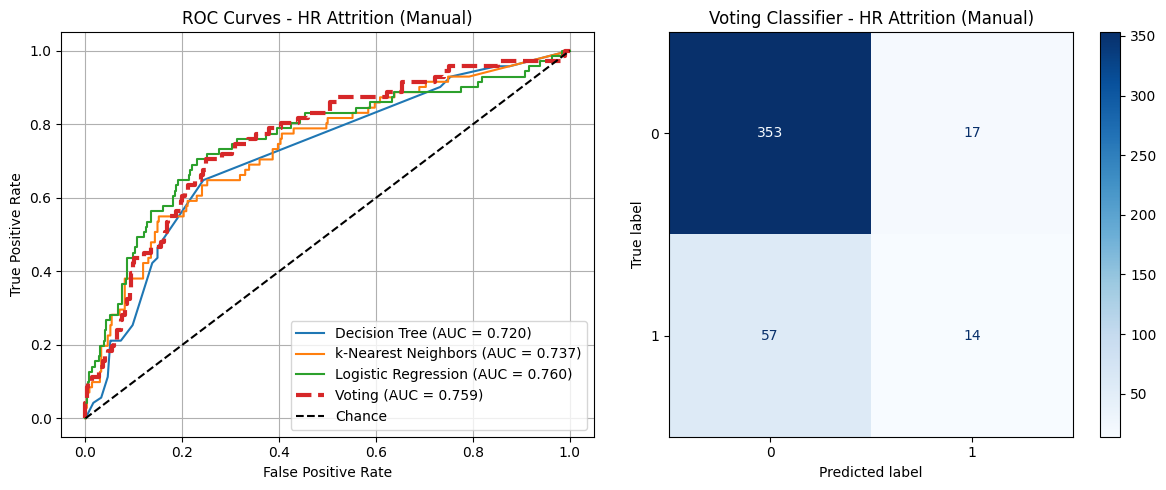


RUNNING BUILT-IN GRID SEARCH FOR HR ATTRITION

--- GridSearchCV for Decision Tree ---
Best params for Decision Tree: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 8, 'classifier__min_samples_split': 2}
Best CV score: 0.7389

--- GridSearchCV for k-Nearest Neighbors ---
Best params for k-Nearest Neighbors: {'classifier__n_neighbors': 19, 'classifier__p': 2, 'classifier__weights': 'distance'}
Best CV score: 0.7526

--- GridSearchCV for Logistic Regression ---


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
35 fits failed out of a total of 210.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **l

Best params for Logistic Regression: {'classifier__C': 100, 'classifier__max_iter': 200, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best CV score: 0.7531

EVALUATING BUILT-IN MODELS FOR HR ATTRITION

--- Individual Model Performance ---

Decision Tree:
  Accuracy: 0.8073
  Precision: 0.3478
  Recall: 0.2254
  F1-Score: 0.2735
  ROC AUC: 0.7199

k-Nearest Neighbors:
  Accuracy: 0.8367
  Precision: 0.4828
  Recall: 0.1972
  F1-Score: 0.2800
  ROC AUC: 0.7370

Logistic Regression:
  Accuracy: 0.8435
  Precision: 0.5385
  Recall: 0.1972
  F1-Score: 0.2887
  ROC AUC: 0.7598

--- Built-in Voting Classifier ---
Voting Classifier Performance:
  Accuracy: 0.8231, Precision: 0.4054
  Recall: 0.2113, F1: 0.2778, AUC: 0.7593


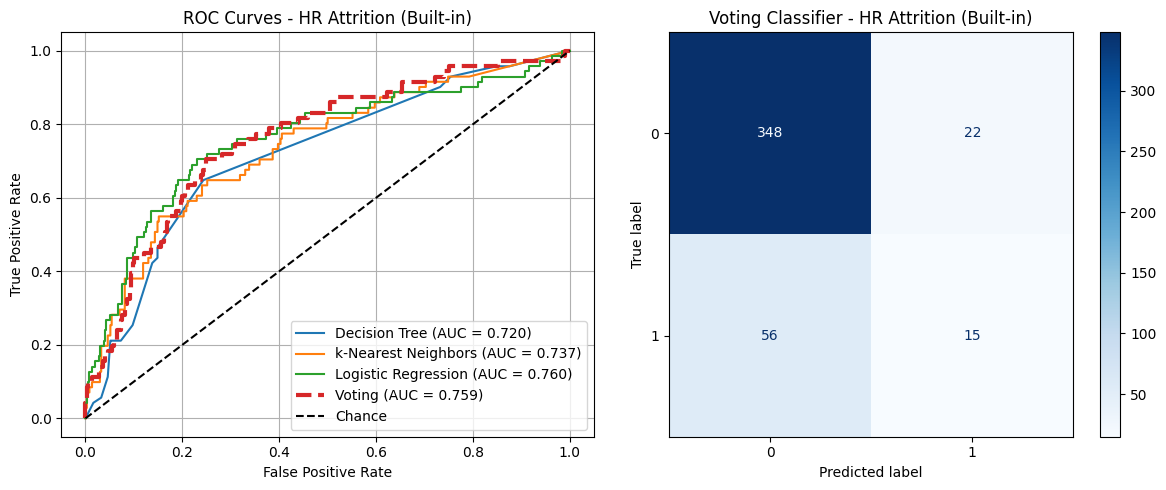


Completed processing for HR Attrition

ALL DATASETS PROCESSED!


In [ ]:
# --- Run Pipeline for All Datasets ---
datasets = [
    # (load_wine_quality, "Wine Quality"),
    (load_hr_attrition, "HR Attrition"),
    # (load_banknote, "Banknote Authentication"),
    # (load_qsar_biodegradation, "QSAR Biodegradation")
]

# Run for each dataset
for dataset_loader, dataset_name in datasets:
    try:
        run_complete_pipeline(dataset_loader, dataset_name)
    except Exception as e:
        print(f"Error processing {dataset_name}: {e}")
        continue

print("\n" + "="*80)
print("ALL DATASETS PROCESSED!")
print("="*80)